In [66]:
import pygame
import random
import numpy as np
import matplotlib.pyplot as plt
import sys

In [67]:
# Game Constants
WIDTH, HEIGHT = 600, 400
CELL_SIZE = 20
FPS = 60
WHITE = (255, 255, 255)
BLACK = (0, 0, 0)
GREEN = (0, 255, 0)
RED = (255, 0, 0)

# Directions
UP = (0, -CELL_SIZE)
DOWN = (0, CELL_SIZE)
LEFT = (-CELL_SIZE, 0)
RIGHT = (CELL_SIZE, 0)
DIRECTIONS = [UP, DOWN, LEFT, RIGHT]

pygame.init()
screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("Snake Q-Learning")
clock = pygame.time.Clock()
font = pygame.font.SysFont('Arial', 25)

In [68]:
# Drawing Helpers
def draw_snake(snake):
    for block in snake:
        pygame.draw.rect(screen, GREEN, pygame.Rect(block[0], block[1], CELL_SIZE, CELL_SIZE))

def draw_food(food):
    pygame.draw.rect(screen, RED, pygame.Rect(food[0], food[1], CELL_SIZE, CELL_SIZE))

def draw_text(text, pos):
    surface = font.render(text, True, WHITE)
    screen.blit(surface, pos)

In [69]:
# Game Environment
class SnakeGame:
    def __init__(self):
        self.reset()

    def reset(self):
        self.snake = [(100, 100)]
        self.direction = RIGHT
        self.spawn_food()
        self.score = 0

    def spawn_food(self):
        while True:
            x = random.randint(0, WIDTH // CELL_SIZE - 1) * CELL_SIZE
            y = random.randint(0, HEIGHT // CELL_SIZE - 1) * CELL_SIZE
            if (x, y) not in self.snake:
                self.food = (x, y)
                break

    def get_state(self):
        head = self.snake[0]
        dx, dy = self.direction
        food_dx = np.sign(self.food[0] - head[0])
        food_dy = np.sign(self.food[1] - head[1])

        def danger(a, b):
            nx, ny = head[0] + a * CELL_SIZE, head[1] + b * CELL_SIZE
            return (nx, ny) in self.snake or nx < 0 or ny < 0 or nx >= WIDTH or ny >= HEIGHT

        return (
            dx, dy,
            food_dx, food_dy,
            danger(1, 0),
            danger(-1, 0),
            danger(0, 1),
            danger(0, -1)
        )

    def play_step(self, action):  # action: 0-UP, 1-DOWN, 2-LEFT, 3-RIGHT
        self.direction = DIRECTIONS[action]
        head = self.snake[0]
        new_head = (head[0] + self.direction[0], head[1] + self.direction[1])
        self.snake.insert(0, new_head)

        if (
            new_head in self.snake[1:] or
            new_head[0] < 0 or new_head[0] >= WIDTH or
            new_head[1] < 0 or new_head[1] >= HEIGHT
        ):
            return -10, True, self.score

        reward = -0.1
        if new_head == self.food:
            self.score += 1
            reward = 10
            self.spawn_food()
        else:
            self.snake.pop()

        return reward, False, self.score

    def render(self):
        screen.fill(BLACK)
        draw_snake(self.snake)
        draw_food(self.food)
        draw_text(f"Score: {self.score}", (10, 10))
        pygame.display.flip()
        clock.tick(FPS)

In [70]:
# Q-Learning Agent
class QLearningAgent:
    def __init__(self, alpha=0.1, gamma=0.9, epsilon=1.0, min_epsilon=0.01, epsilon_decay=0.995):
        self.q_table = {}
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.epsilon_decay = epsilon_decay

    def get_action(self, state):
        if state not in self.q_table:
            self.q_table[state] = np.zeros(4)
        if random.random() < self.epsilon:
            return random.randint(0, 3)
        return np.argmax(self.q_table[state])

    def update(self, state, action, reward, next_state, done):
        if state not in self.q_table:
            self.q_table[state] = np.zeros(4)
        if next_state not in self.q_table:
            self.q_table[next_state] = np.zeros(4)

        best_next = 0 if done else np.max(self.q_table[next_state])
        td_target = reward + self.gamma * best_next
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.alpha * td_error

    def decay_epsilon(self):
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

In [71]:
# Training Loop
EPISODES = 500
RENDER = True
RENDER_EVERY = 10

env = SnakeGame()
agent = QLearningAgent()
scores = []

for episode in range(EPISODES):
    env.reset()
    state = env.get_state()
    total_reward = 0

    while True:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit(); sys.exit()

        action = agent.get_action(state)
        reward, done, score = env.play_step(action)
        next_state = env.get_state()
        agent.update(state, action, reward, next_state, done)

        state = next_state
        total_reward += reward

        if RENDER and episode % RENDER_EVERY == 0:
            env.render()

        if done:
            scores.append(score)
            print(f"Episode {episode+1}: Score = {score}, Epsilon = {agent.epsilon:.3f}")
            break

    agent.decay_epsilon()

Episode 1: Score = 0, Epsilon = 1.000
Episode 2: Score = 0, Epsilon = 0.995
Episode 3: Score = 0, Epsilon = 0.990
Episode 4: Score = 0, Epsilon = 0.985
Episode 5: Score = 0, Epsilon = 0.980
Episode 6: Score = 0, Epsilon = 0.975
Episode 7: Score = 0, Epsilon = 0.970
Episode 8: Score = 0, Epsilon = 0.966
Episode 9: Score = 0, Epsilon = 0.961
Episode 10: Score = 0, Epsilon = 0.956
Episode 11: Score = 0, Epsilon = 0.951
Episode 12: Score = 0, Epsilon = 0.946
Episode 13: Score = 0, Epsilon = 0.942
Episode 14: Score = 0, Epsilon = 0.937
Episode 15: Score = 0, Epsilon = 0.932
Episode 16: Score = 0, Epsilon = 0.928
Episode 17: Score = 0, Epsilon = 0.923
Episode 18: Score = 0, Epsilon = 0.918
Episode 19: Score = 0, Epsilon = 0.914
Episode 20: Score = 0, Epsilon = 0.909
Episode 21: Score = 0, Epsilon = 0.905
Episode 22: Score = 0, Epsilon = 0.900
Episode 23: Score = 0, Epsilon = 0.896
Episode 24: Score = 0, Epsilon = 0.891
Episode 25: Score = 0, Epsilon = 0.887
Episode 26: Score = 0, Epsilon = 0

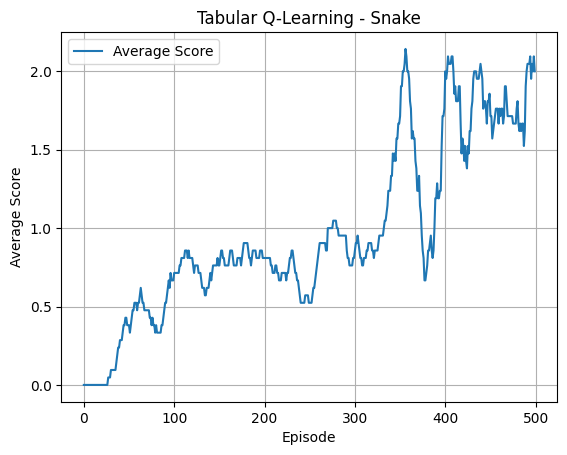

In [72]:
# Plot
window_size = 20
avg_scores = [np.mean(scores[max(0, i - window_size):(i + 1)]) for i in range(len(scores))]
plt.plot(avg_scores, label="Average Score")
plt.xlabel("Episode")
plt.ylabel("Average Score")
plt.title("Tabular Q-Learning - Snake")
plt.grid(True)
plt.legend()
plt.show()